In [1]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import contractions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn . model_selection import train_test_split
from sklearn . feature_extraction . text import TfidfVectorizer
from sklearn . preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn . metrics import accuracy_score


In [2]:
df = pd.read_csv(r"D:\merged_partition_content\Tu_Hoc\AIO2025\Docs\Module03\Week06\W6-20260101T065402Z-3-001\W6\Sunday-20260101T065813Z-3-001\Sunday\Description\data\IMDB-Dataset.csv")
## xoá các dòng trùng
df = df.drop_duplicates()

In [3]:
# Tải các tài nguyên cần thiết từ NLTK
nltk.download('stopwords')
nltk.download('wordnet')

# Khởi tạo tập hợp từ dừng (stopwords)
stop = set(stopwords.words('english'))

def expand_contractions(txt):
    """
    Mở rộng các từ viết tắt thành dạng đầy đủ.
    Ví dụ: "can't" -> "cannot", "I'm" -> "I am".
    [cite_start]Mục đích: Giúp máy hiểu rõ ngữ nghĩa (phủ định/khẳng định)[cite: 216].
    """
    return contractions.fix(txt)

def preprocessing_text(txt):
    """
    [cite_start]Hàm thực hiện toàn bộ quy trình làm sạch và chuẩn hóa văn bản[cite: 890].
    """
    wl = WordNetLemmatizer()

    # 1. Loại bỏ thẻ HTML
    # [cite_start]Sử dụng BeautifulSoup để lấy nội dung chữ, bỏ các thẻ như <div>, <br>[cite: 200, 896].
    soup = BeautifulSoup(txt, "html.parser")
    txt = soup.get_text()

    # 2. Mở rộng từ viết tắt
    txt = expand_contractions(txt)

    # 3. Xóa Emoji và Ký tự đặc biệt
    # [cite_start]Regex chứa các dải mã Unicode của Emoticons, Symbols, Transport, Flags...[cite: 906].
    # Thay thế tất cả bằng chuỗi rỗng.
    emoji_clean = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    txt = emoji_clean.sub(r"", txt)

    # 4. Chuẩn hóa dấu chấm câu
    # Thêm khoảng trắng sau dấu chấm nếu nó bị dính liền với từ tiếp theo (VD: "end.Start" -> "end. Start").
    txt = re.sub(r'\.(?=\S)', '. ', txt)

    # 5. Xóa đường dẫn URL
    # [cite_start]Tìm chuỗi bắt đầu bằng 'http' và theo sau là ký tự không phải khoảng trắng[cite: 943].
    txt = re.sub(r'http\S+', ' ', txt)

    # 6. Chuyển chữ thường & Xóa dấu câu
    # [cite_start]Lưu ý: Vòng lặp này duyệt qua từng KÝ TỰ (char), không phải từ[cite: 945].
    txt = "".join([char.lower() for char in txt if char not in string.punctuation])

    # 7. Tokenization, Lọc Stopwords & Lemmatization
    # - Tách chuỗi thành danh sách từ (split).
    # - Chỉ giữ lại từ không phải stopwords và là chữ cái (isalpha).
    # [cite_start]- Đưa từ về dạng nguyên thể (Lemmatize)[cite: 948, 949].
    tokens = [wl.lemmatize(word) for word in txt.split() if word not in stop and word.isalpha()]
    
    # Nối lại thành chuỗi văn bản hoàn chỉnh
    txt = " ".join(tokens)

    return txt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


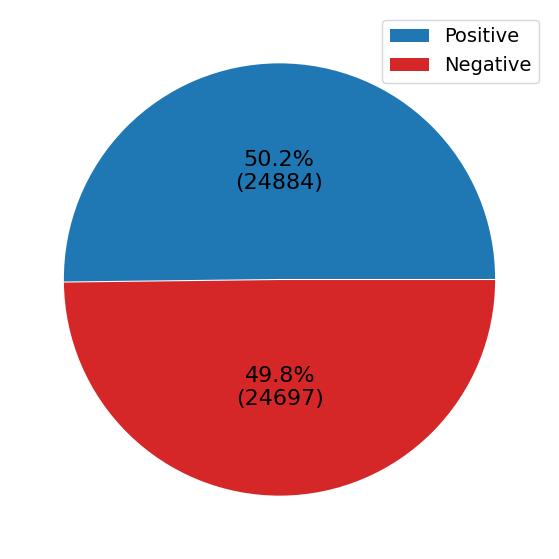

In [4]:
## Phân tích dữ liệu: Thống kê số lượng các nhãn trong bộ dữ liệu
def create_autocpt_arg(pct, val):
    absolute = int(pct / 100 * np.sum(val))
    return  "{:.1f}%\n({:d})".format(pct, absolute)

freq_pos = len(df[df['sentiment'] == 'positive'])
freq_neg = len(df[df['sentiment'] == 'negative'])

data = [freq_pos, freq_neg]

labels = ['positive', 'negative']

pie , ax = plt.subplots( figsize =[11 ,7])

plt.pie( x= data, autopct = lambda pct : create_autocpt_arg(pct, data), explode = [0.0025] * 2, pctdistance = 0.5, colors = [sns.color_palette()[0], 'tab:red'], textprops = {'fontsize':16})

labels = [r'Positive', r'Negative']
plt.legend (labels, loc ="best", fontsize =14)
pie.savefig(r"\pie_chart.png")
plt.show()

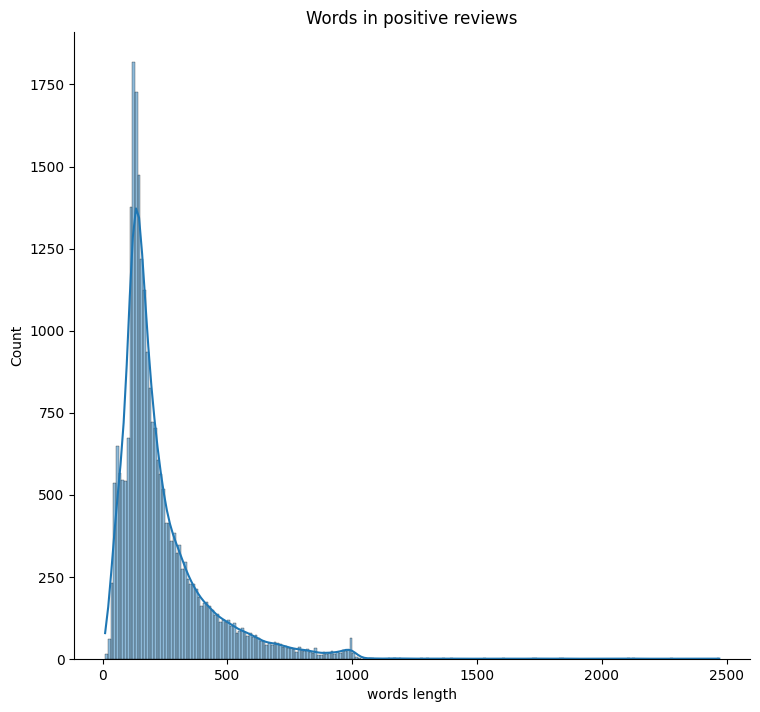

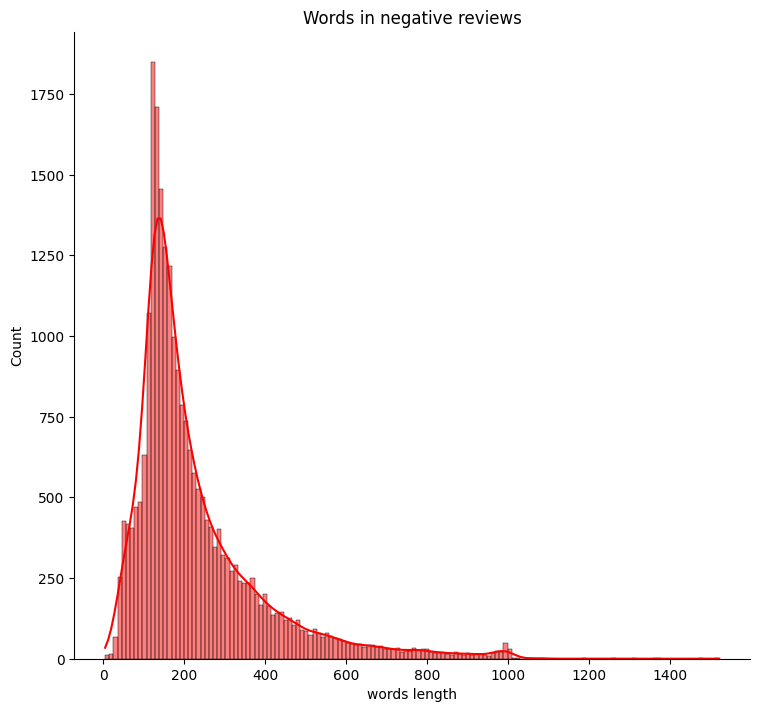

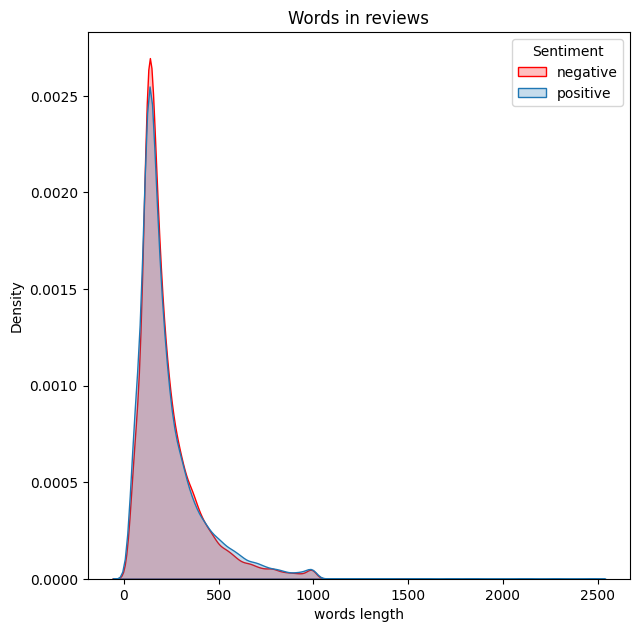

In [5]:
# Giả sử df đã được khai báo trước đó
word_lens = df['review'].str.split().map(lambda x: len(x))
df_temp = df.copy()
df_temp['words length'] = word_lens

# Biểu đồ Positive
hist_pos = sns.displot(
    data=df_temp[df_temp['sentiment'] == 'positive'], 
    x='words length', 
    hue='sentiment', 
    kde=True, 
    height=7, 
    aspect=1.1, 
    legend=False
).set(title='Words in positive reviews')
hist_pos.savefig("hist_pos.png") # Sửa đường dẫn file

# Biểu đồ Negative
hist_neg = sns.displot(
    data=df_temp[df_temp['sentiment'] == 'negative'], 
    x='words length', 
    hue='sentiment', 
    kde=True, 
    height=7, 
    aspect=1.1, 
    legend=False,
    palette=['red'] # Thêm palette màu đỏ cho đúng logic
).set(title='Words in negative reviews')
hist_neg.savefig("hist_neg.png") # Sửa đường dẫn file

# Biểu đồ KDE (Kernel Density Estimate)
plt.figure(figsize=(7, 7.1))

# Sửa lỗi khoảng trắng và tên cột
kernel_distribution_number_words_plot = sns.kdeplot(
    data=df_temp, 
    x="words length",       # Sửa: bỏ khoảng trắng thừa
    hue="sentiment",        # Sửa: bỏ khoảng trắng thừa
    fill=True, 
    palette=[sns.color_palette()[0], 'red'] # Sửa: bỏ khoảng trắng thừa trong sns.color_palette
).set(title='Words in reviews')

plt.legend(title='Sentiment', labels=['negative', 'positive'])

# Sửa: plt.show() không cần tham số
plt.show()

In [6]:
## Chia tập train và test:
label_encode = LabelEncoder()
y_data = label_encode.fit_transform(df["sentiment"])
X_train, X_test, y_train, y_test = train_test_split(df["review"], y_data, test_size=0.2, random_state=42)

In [7]:
## Biểu diễn văn bản thành vector:
tfidf = TfidfVectorizer(max_features = 10000)
tfidf.fit(X_train, y_train)

x_train_encoder = tfidf.transform(X_train)
x_test_encoder = tfidf.transform(X_test)

In [10]:
# Khởi tạo mô hình AdaBoost
adb_classifier = AdaBoostClassifier(
    n_estimators=100, 
    random_state=42
)

# Huấn luyện mô hình
adb_classifier.fit(x_train_encoder, y_train)

# Dự đoán và đánh giá
ADA_y_pred = adb_classifier.predict(x_test_encoder)
print("AdaBoost Accuracy:", accuracy_score(ADA_y_pred, y_test))

AdaBoost Accuracy: 0.767268327115055


In [9]:
dtree_classifier = DecisionTreeClassifier(
    criterion = 'gini',random_state=42
 )
dtree_classifier.fit(x_train_encoder, y_train)
print('Decision Tree Accuracy:', accuracy_score(dtree_classifier.predict(x_test_encoder), y_test))

Decision Tree Accuracy: 0.70646364828073


In [11]:
rf_classifier = RandomForestClassifier(random_state = 42)
rf_classifier.fit(x_train_encoder, y_train)
print('Random Forest Accuracy:', accuracy_score(rf_classifier.predict(x_test_encoder), y_test))

Random Forest Accuracy: 0.8401734395482505


In [12]:
gb_classifier = GradientBoostingClassifier(random_state=42)
gb_classifier.fit(x_train_encoder, y_train)
print('Gradient Boosting Accuracy:', accuracy_score(gb_classifier.predict(x_test_encoder), y_test))

Gradient Boosting Accuracy: 0.8009478672985783


In [13]:
xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_classifier.fit(x_train_encoder, y_train)
print('XGBoost Accuracy:', accuracy_score(xgb_classifier.predict(x_test_encoder), y_test))  

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:48:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.8518705253604921


In [ ]:
import joblib

# Giả sử bạn đã train xong và có các biến này:
# 1. tfidf_vectorizer (đã fit)
# 2. rf_classifier (đã fit)

print("Đang lưu model và vectorizer...")


joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

# Lưu Model (Ví dụ Random Forest)
joblib.dump(adb_classifier, 'ADA_model.pkl')
joblib.dump(rf_classifier, 'rf_model.pkl')
joblib.dump(dtree_classifier, 'dtree_model.pkl')
joblib.dump(gb_classifier, 'gb_model.pkl')  
joblib.dump(xgb_classifier, 'xgb_model.pkl')


print("Đã lưu thành công! Giờ bạn có thể tắt máy.")